# Discounted Random Chain, 5000 episodes
gamma = 0.8

In [4]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read CSV into DataFrame

In [5]:
exp_csv_path = '../data/1003-ex24_SRE-SR-combined_5000epis.csv'

cur_df = pd.read_csv(exp_csv_path, sep='\|\|')
data_df = cur_df.drop(cur_df.columns[0], axis=1)

print(len(data_df))
data_df[0:5]

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


1500000


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,use_rand_s_mat,use_true_r_fn,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
0,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,0,30,1.0,0.507322,0.497230,0.499603,0.459020,None,2.300710
1,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,1,114,1.0,0.513481,0.479716,0.494239,0.452793,None,2.297178
2,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,2,232,1.0,0.519630,0.441237,0.481855,0.439328,None,2.282706
3,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,3,22,1.0,0.525616,0.440407,0.481855,0.438896,None,2.282576
4,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,4,102,1.0,0.532643,0.429458,0.477518,0.434333,None,2.279774


## Get runs form a specific episode

In [6]:
epis_idx_filter = 4999

epis_data_df = data_df[data_df['episode_idx']==epis_idx_filter]

print(len(epis_data_df))
epis_data_df[0:3]

300


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,use_rand_s_mat,use_true_r_fn,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
4999,5000,19,STraceAgent,0,0.8,0.005,1.0,0.05,False,False,True,4999,130,0.0,0.929384,-0.006228,0.118557,0.114609,None,0.410533
9999,5000,19,SRAgent,0,0.8,0.005,1.0,0.05,False,False,True,4999,130,0.0,1.168530,0.122138,0.449410,0.505669,None,0.410533
14999,5000,19,STraceAgent,2,0.8,0.005,1.0,0.05,False,False,True,4999,94,0.0,0.922174,-0.009191,0.117107,0.112816,None,0.421750


#### Get different sub-DataFrames depending on the run

In [7]:
from itertools import product

indep_cols = ['agentCls_name', 'use_true_s_mat']

# Get all the different combinations of independent cols
indep_col_val_list = []
for indep_col in indep_cols:
    indep_col_val_list.append( list(set(epis_data_df[indep_col].values)) )
indep_col_val_cartesian_prod = product(*indep_col_val_list)

# Filter for sub-dataframes, one for each combination
indep_col_df_dict = {}

for val_tup in indep_col_val_cartesian_prod:    
    # Filter
    cur_df = epis_data_df.copy(deep=True)
    for i in range(len(indep_cols)):
        cur_indep_col = indep_cols[i]
        cur_df = cur_df[cur_df[cur_indep_col] == val_tup[i]]
    
    # Save
    if len(cur_df) > 0:
        cur_comb_name = '_'.join([str(e) for e in list(val_tup)])
        indep_col_df_dict[cur_comb_name] = cur_df
    
# Print
for k in indep_col_df_dict:
    print(k, len(indep_col_df_dict[k]))

STraceAgent_False 150
SRAgent_False 150


### Plot RMSE

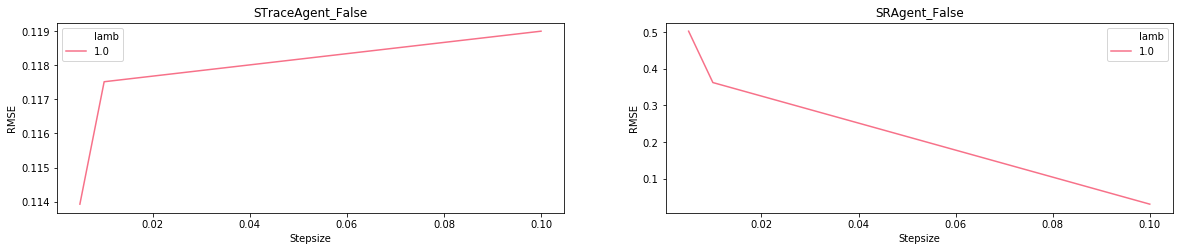

In [8]:
# ==
# Specify plots
plot_x = 'lr'
plot_y = 'v_vec_rmse'
plot_hue = 'lamb'
plot_ci = None  # Estimator, [None, 'sd']


# ==
# Plot

plt.figure(figsize=(20, 3.5))

# Generate subplots
total_n_plots = len(indep_col_df_dict)
n_plot_counter = 1
for k in indep_col_df_dict:
    # Current
    cur_df = indep_col_df_dict[k]
    
    # Generate palette
    n_hues = len(set(cur_df[plot_hue].values))
    c_palette = sns.color_palette("husl", n_hues)
    
    # Plot
    plt.subplot(1, total_n_plots, n_plot_counter)
    sns.lineplot(x=plot_x, y=plot_y, hue=plot_hue, 
                 ci=plot_ci, 
                 palette = c_palette,
                 data=cur_df)
    
    
    #plt.ylim([0, 0.3])
    plt.ylabel('RMSE')
    plt.xlabel('Stepsize')
    plt.title(str(k))
    
    # Counter var
    n_plot_counter += 1
    


#### Group things

In [9]:
grouped_epis_df = epis_data_df.groupby(['agentCls_name', 'lamb', 'lr']).mean()
grouped_epis_df = grouped_epis_df[grouped_epis_df['v_vec_rmse']<0.2]

del grouped_epis_df['cumulative_reward']
del grouped_epis_df['gamma']
del grouped_epis_df['n_states']
del grouped_epis_df['num_episodes']
del grouped_epis_df['s_subsample_prop']
del grouped_epis_df['seed']
del grouped_epis_df['total_steps']
del grouped_epis_df['episode_idx']

grouped_epis_df

use_true_s_mat  use_rand_s_mat  use_true_r_fn  \
agentCls_name lamb lr                                                     
SRAgent       1.0  0.100           False           False           True   
STraceAgent   1.0  0.005           False           False           True   
                   0.010           False           False           True   
                   0.100           False           False           True   

                          v_vec_max  v_vec_min  v_vec_avg  v_vec_rmse  \
agentCls_name lamb lr                                                   
SRAgent       1.0  0.100   0.686071   0.000813   0.080517    0.029902   
STraceAgent   1.0  0.005   0.925874  -0.009793   0.117793    0.113925   
                   0.010   0.925637  -0.004456   0.124471    0.117516   
                   0.100   0.926922  -0.000059   0.126909    0.118999   

                          s_mat_rmse  
agentCls_name lamb lr                 
SRAgent       1.0  0.100    0.089984  
STraceAgent   1.0  0.005    0.416187  
                   0.010    0.275251  
                   0.100    0.089984

## Plot training progress

In [10]:
tmp_df = data_df.copy(deep=True)
tmp_df = tmp_df[tmp_df['agentCls_name']=='SRAgent']
sorted(list(set(tmp_df['lr'].values)))

[0.005, 0.01, 0.1]

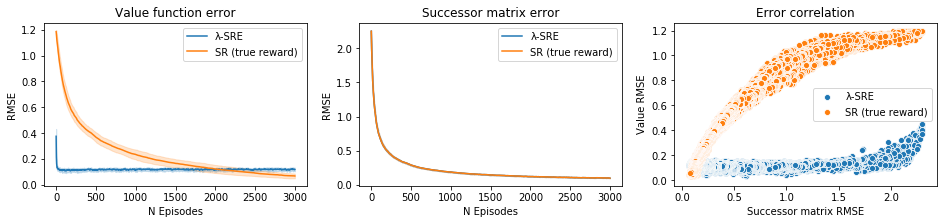

In [11]:
def script_plot_training_progress(in_data_df):

    # ==
    # Filter for dataframe
    cur_df = in_data_df.copy(deep=True)

    epis_limit = 3000

    # Make the Lambda return agent
    cur_df1 = cur_df[cur_df['agentCls_name']=='STraceAgent']
    cur_df1 = cur_df1[cur_df1['lr'] == 0.10]
    cur_df1 = cur_df1[cur_df1['episode_idx'] < epis_limit]


    # Make the STrace agent dataframe
    cur_df2 = cur_df[cur_df['agentCls_name']=='SRAgent']
    cur_df2 = cur_df2[cur_df2['lr'] == 0.10]
    cur_df2 = cur_df2[cur_df2['episode_idx'] < epis_limit]



    # ==
    # Generate plots

    plt.figure(figsize=(16,3))

    # ==
    # Plot value RMSE
    plt.subplot(1,3,1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci='sd', data=cur_df1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', ci='sd', data=cur_df2)

    #plt.ylim([-0.01, 0.5])
    plt.legend(['λ-SRE', 'SR (true reward)'])
    plt.ylabel('RMSE')
    plt.xlabel('N Episodes')
    plt.title('Value function error')


    # ==
    # Plot successor matrix RMSE
    plt.subplot(1,3,2)
    sns.lineplot(x='episode_idx', y='s_mat_rmse', ci=95, n_boot=20, data=cur_df1)
    sns.lineplot(x='episode_idx', y='s_mat_rmse', ci=95, n_boot=20, data=cur_df2)

    plt.legend(['λ-SRE', 'SR (true reward)'])
    plt.ylabel('RMSE')
    plt.xlabel('N Episodes')
    plt.title('Successor matrix error')


    # ==
    # Plot how the two errors correlate
    # ==
    # Plot error with against each other
    plt.subplot(1,3,3)
    sns.scatterplot(x='s_mat_rmse', y='v_vec_rmse', 
                    ci=95, n_boot=20,
                    data=cur_df1)
    sns.scatterplot(x='s_mat_rmse', y='v_vec_rmse', 
                    ci=95, n_boot=20, markers=False,
                    data=cur_df2)

    plt.legend(['λ-SRE', 'SR (true reward)'])
    plt.ylabel('Value RMSE')
    plt.xlabel('Successor matrix RMSE')
    plt.title('Error correlation')


    plt.show()

script_plot_training_progress(data_df)

**Bigger plot**

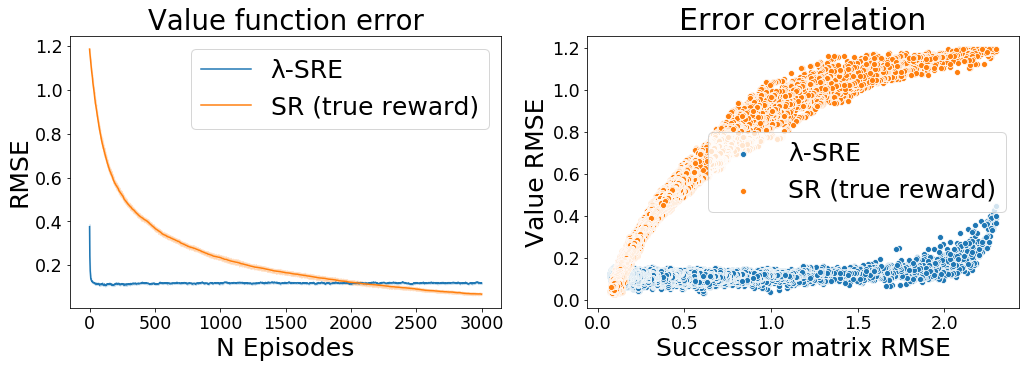

In [27]:
def script_big_plot_training_progress(in_data_df):
    plt_figsize = (17,5)
    plt_fontsize = 25
    
    plt_ci = 95  # 95
    plt_n_boot = 50  # 50
    

    # ==
    # Filter for dataframe
    cur_df = in_data_df.copy(deep=True)

    epis_limit = 3000

    # Make the Lambda return agent
    cur_df1 = cur_df[cur_df['agentCls_name']=='STraceAgent']
    cur_df1 = cur_df1[cur_df1['lr'] == 0.10]
    cur_df1 = cur_df1[cur_df1['episode_idx'] < epis_limit]


    # Make the STrace agent dataframe
    cur_df2 = cur_df[cur_df['agentCls_name']=='SRAgent']
    cur_df2 = cur_df2[cur_df2['lr'] == 0.10]
    cur_df2 = cur_df2[cur_df2['episode_idx'] < epis_limit]



    # ==
    # Generate plots

    plt.figure(figsize=plt_figsize)

    # ==
    # Plot value RMSE
    plt.subplot(1,2,1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', 
                 ci=plt_ci, n_boot=plt_n_boot, 
                 data=cur_df1)
    sns.lineplot(x='episode_idx', y='v_vec_rmse', 
                 ci=plt_ci, n_boot=plt_n_boot, 
                 data=cur_df2)

    #plt.ylim([-0.01, 0.5])
    plt.legend(['λ-SRE', 'SR (true reward)'], fontsize=plt_fontsize)
    plt.ylabel('RMSE', fontsize=plt_fontsize)
    plt.xlabel('N Episodes', fontsize=plt_fontsize)
    plt.title('Value function error', fontsize=(plt_fontsize*1.1))
    
    plt.xticks(fontsize=(plt_fontsize*0.7))
    plt.yticks(fontsize=(plt_fontsize*0.7))


    # ==
    # Plot how the two errors correlate
    # ==
    # Plot error with against each other
    plt.subplot(1,2,2)
    sns.scatterplot(x='s_mat_rmse', y='v_vec_rmse', 
                    ci=plt_ci, n_boot=plt_n_boot,
                    data=cur_df1)
    sns.scatterplot(x='s_mat_rmse', y='v_vec_rmse', 
                    ci=plt_ci, n_boot=plt_n_boot, markers=False,
                    data=cur_df2)

    plt.legend(['λ-SRE', 'SR (true reward)'], fontsize=plt_fontsize)
    plt.ylabel('Value RMSE', fontsize=plt_fontsize)
    plt.xlabel('Successor matrix RMSE', fontsize=plt_fontsize)
    plt.title('Error correlation', fontsize=(plt_fontsize*1.2))
    
    plt.xticks(fontsize=(plt_fontsize*0.7))
    plt.yticks(fontsize=(plt_fontsize*0.7))

    plt.show()

script_big_plot_training_progress(data_df)